## NYC Taxi Data Machine Learning

This notebook demonstrates how to run some machine learning models on the NYC taxi data with scikit-learn machine learning models.

We start with exploratory data analysis and data cleaning.  The data is surprisingly messy.

After the data is cleaned, we turn our attention to running ML models and assessing the accuracy of our predictions.

You'll notice that some of the machine learning models take a long time to train, even when only a tiny sliver of the overall dataset is used.

Machine learning is computationally expensive even when the dataset is small.

Performance bottlenecks can prevent scientists from training models on large datasets.  Scientists need to leverage technologies like Dask to run these models on big data.  The next notebook will focus on running these computations in a performant manner.

## Read the data

In [77]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [78]:
dtype = {
    "payment_type": "UInt8",
    "VendorID": "UInt8",
    "passenger_count": "UInt8",
    "RatecodeID": "UInt8",
    "store_and_fwd_flag": "category",
    "PULocationID": "UInt16",
    "DOLocationID": "UInt16",
}

In [79]:
path = "/Users/powers/Downloads/yellow_tripdata_2009-01.csv"
train = pd.read_csv(path, nrows = 1000000, dtype=dtype, parse_dates=["Trip_Pickup_DateTime"])

In [80]:
train = train.rename(
  columns={
#     "Trip_Pickup_DateTime": "key",
    "Fare_Amt": "fare_amount", 
    "Trip_Pickup_DateTime": "pickup_datetime",
    "Trip_Distance": "abs_distance",
    "Start_Lon": "pickup_longitude",
    "Start_Lat": "pickup_latitude",
    "End_Lon": "dropoff_longitude",
    "End_Lat": "dropoff_latitude",
    "Passenger_Count": "passenger_count"
  }
)



In [81]:
train = train[[
    "fare_amount",
    "pickup_datetime",
    "abs_distance",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count"
]]

## Exploratory Data Analysis

In [82]:
train.head(10)

,fare_amount,pickup_datetime,abs_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,8.9,2009-01-04 02:52:00,2.63,-73.991957,40.721567,-73.993803,40.695922,1
1,12.1,2009-01-04 03:31:00,4.55,-73.982102,40.736290,-73.955850,40.768030,3
2,23.7,2009-01-03 15:43:00,10.35,-74.002587,40.739748,-73.869983,40.770225,5
3,14.9,2009-01-01 20:52:58,5.00,-73.974267,40.790955,-73.996558,40.731849,1
4,3.7,2009-01-24 16:18:23,0.40,-74.001580,40.719382,-74.008378,40.720350,1
5,6.1,2009-01-16 22:35:59,1.20,-73.989806,40.735006,-73.985021,40.724494,2
6,5.7,2009-01-21 08:55:57,0.40,-73.984050,40.743544,-73.980260,40.748926,1
7,6.1,2009-01-04 04:31:00,1.72,-73.992635,40.748362,-73.995585,40.728307,1
8,8.7,2009-01-05 16:29:02,1.60,-73.969690,40.749244,-73.990413,40.751082,1
9,5.9,2009-01-05 18:53:13,0.70,-73.955173,40.783044,-73.958598,40.774822,1


Drop the missing data

In [83]:
train = train.dropna()

Add columns that show the year, day-of-week, and hour for each pickup because these may be factors that explain the overall fare.

In [84]:
train["pickup_datetime"] = pd.to_datetime(train["pickup_datetime"])
train["pickup_year"] = train["pickup_datetime"].dt.year
train["pickup_dow"] = train["pickup_datetime"].dt.dayofweek
train["pickup_hour"] = train["pickup_datetime"].dt.hour

In Pandas, Monday is 0 and Sunday is 6.  Let's plot the average fare amount by day of week and see that fares tend to be higher on Saturday.

<AxesSubplot:xlabel='pickup_dow'>

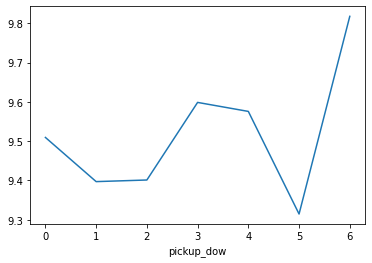

In [85]:
train.groupby("pickup_dow")["fare_amount"].mean().plot()

Let's also plot the fare by pickup hour and observe that fares are generally higher late at night / really early in the morning.

<AxesSubplot:xlabel='pickup_hour'>

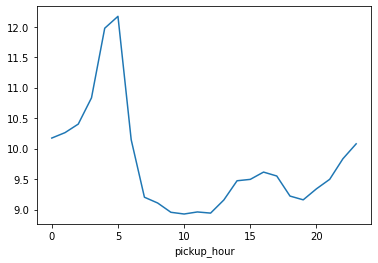

In [32]:
train.groupby("pickup_hour")["fare_amount"].mean().plot()

Let's plot the distance of the trip vs the fare amount and observe the positive correlation.  There are a lot of weird outliers in the data.  Trips that are short & cost a lot / trips that are long & don't cost much at all.

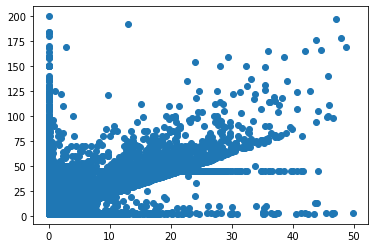

In [33]:
plt.scatter(train["abs_distance"], train["fare_amount"])

Let's look at the lat / long coordinates for some trips and see that there are clearly some data points that are irregular.  NYC is 40.7 (lat) and -70.9 (long).  There are clearly some lat/long coordinates that don't make sense in the data.

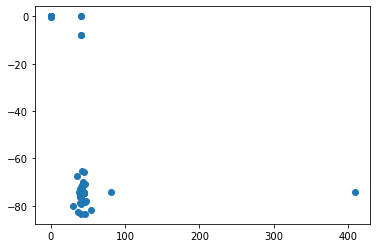

In [36]:
plt.scatter(train["pickup_latitude"], train["pickup_longitude"])

In [47]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_dow,pickup_hour,move_latitude,move_longitude,abs_distance
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000,1000000.00000,1000000.000000,1000000.000000,1000000.000000
mean,9.509305,-72.854071,40.136485,-72.872051,40.146706,1.716341,2009.0,3.173156,13.66919,1.134570,-1.528288,5.805853
std,7.204505,9.036628,4.991860,8.960220,4.936660,1.278965,0.0,1.884256,6.44146,93.872869,118.118614,150.778106
min,2.500000,-83.432169,-0.070208,-83.432169,-0.063655,0.000000,2009.0,0.000000,0.00000,-40889.907717,-6401.079530,0.000000
25%,5.400000,-73.991463,40.736417,-73.990974,40.735454,1.000000,2009.0,2.000000,9.00000,-1.411698,-0.903125,1.145508
50%,7.300000,-73.981423,40.753958,-73.979780,40.754256,1.000000,2009.0,3.000000,15.00000,0.000000,0.026180,1.981049
75%,10.600000,-73.967456,40.768135,-73.964072,40.769249,2.000000,2009.0,5.000000,19.00000,1.439448,1.087065,3.564567
max,200.000000,0.031645,409.133332,0.032062,81.535005,6.000000,2009.0,6.000000,23.00000,4535.760588,6297.819660,40889.907726


We're going to drop the following data:

* lat/long coordinates that don't make sense
* fares less than the minimum (2.5)
* trips over 100 miles

In [86]:
train = train[train["fare_amount"] >= 2.5]

longtitude_range = (train["pickup_longitude"] <= -73.4) & (train["pickup_longitude"]  >= -74.4)
latitude_range = (train["pickup_latitude"] <= 41.2) & (train["pickup_latitude"] >= 40.2)
train_trim = train[longtitude_range & latitude_range]

train_trim = train_trim[(train_trim["abs_distance"] < 100) & (train_trim["abs_distance"] > 0)]

We can see that 2.5% of the data was abnormal and "trimmed" with our filtering.

In [87]:
train_trim.shape[0]/train.shape[0]

0.975224

See the below plot on distance vs fare and observe the data looks more reasonable.  We can still see there are a lot of really long trips that have a really cheap fare, so looks like even more data cleaning is needed, but let's forge ahead.

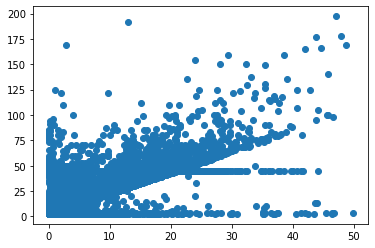

In [45]:
plt.scatter(train_trim["abs_distance"], train_trim["fare_amount"])

Let's see the correlation of the total fare with other variables.  The total fare is most highly correlated with the trip distance and the pickup longitude.

In [43]:
train_trim.corr()["fare_amount"].sort_values(ascending = False)

fare_amount          1.000000
abs_distance         0.946698
pickup_longitude     0.370617
dropoff_longitude    0.021076
pickup_dow           0.006840
passenger_count      0.003776
dropoff_latitude    -0.018598
pickup_hour         -0.021891
pickup_latitude     -0.198434
pickup_year               NaN
Name: fare_amount, dtype: float64

Plot the fare amount by pickup longitude and see that there are a lot of really expensive trips at a longitude of around -73.9.  Looks like a lot of folks take expensive cab rides out of Manhattan.  Probably workers leaving the office late and using a corporate credit card to get home ;)

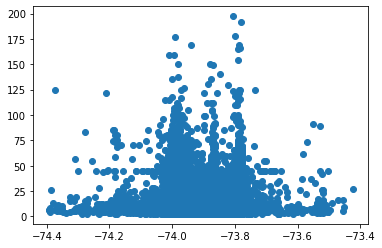

In [44]:
plt.scatter(train_trim["pickup_longitude"], train_trim["fare_amount"])

## Machine Learning

This section runs linear and random forest regressions.

The random forest regression has a lower root square mean error, so it's more accurate.  The following cells show how to train the models and compute the RSME.

We then show how to run the random forest regression model on test data to see how the estimated fares line up with actual results.

In [88]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.compose import ColumnTransformer

## Features Preprocessing Pipeline

In [48]:
## group pickup hour into bins in order to reduce model runtime
class HourlyBins(BaseEstimator, TransformerMixin): 
    def __init__(self, bins = 8):
        self.bins = bins
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):    
        pickup_hour_bin = np.array(pd.cut(X[X.columns[0]], self.bins))
        return pickup_hour_bin.reshape(-1, 1)

In [49]:
hour_pipe = Pipeline([
    ('hourlybins', HourlyBins()),
    ('encoder', OneHotEncoder(categories='auto', sparse = False)),
])

ct_pipe = ColumnTransformer(transformers=[
    ('hourly_cat', hour_pipe, ["pickup_hour"]),
    ('encoder', OneHotEncoder(categories='auto', sparse = False), ["pickup_dow"]),
    ('std_scaler', StandardScaler(), ["pickup_year", "abs_distance", "pickup_longitude", "dropoff_longitude"])
])

In [50]:
## build a function that can break raw data into independent variables and dependent variable for the models
def XandY(df, test_set = False):
    df = df.copy()
    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
    df["pickup_year"] = df["pickup_datetime"].dt.year.astype(float)
    df["pickup_dow"] = df["pickup_datetime"].dt.dayofweek
    df["pickup_hour"] = df["pickup_datetime"].dt.hour
    df["abs_distance"] = np.hypot(df["dropoff_latitude"]-df["pickup_latitude"], df["dropoff_longitude"]-df["pickup_longitude"])
    df_X = df[["pickup_year", "pickup_dow", "pickup_hour", "abs_distance", "pickup_longitude", "dropoff_longitude"]]
    if test_set == True:
        return df_X
    else:
        df_y = df["fare_amount"]
        return df_X, df_y

train_X, train_y = XandY(train_trim)

## Linear Regression

In [51]:
lr_pipe = Pipeline([
    ('ct', ct_pipe),
    ('lin_reg', LinearRegression())
]) 
lr_score = cross_val_score(lr_pipe, train_X, train_y, scoring = "neg_mean_squared_error", cv = 5)
lr_rmse = np.sqrt(-lr_score)
lr_rmse.mean()

5.847354676391356

## Random Forest Regression

In [52]:
rfr_pipe = Pipeline([
    ('ct', ct_pipe),
    ('forest_reg', RandomForestRegressor(n_estimators = 10, n_jobs = -1, random_state = 3))
])

rfr_score = cross_val_score(rfr_pipe, train_X, train_y, scoring = "neg_mean_squared_error", cv = 5)
rfr_rmse = np.sqrt(-rfr_score)
rfr_rmse.mean()

2.7445893362457534

In [53]:
param_grid = {'forest_reg__n_estimators': [10, 20], 'forest_reg__max_features': [4, 8, 'auto']}
forest_gs = GridSearchCV(rfr_pipe, param_grid, cv = 5, scoring = "neg_mean_squared_error")
forest_gs.fit(train_X, train_y)
forest_gs.best_params_

{'forest_reg__max_features': 8, 'forest_reg__n_estimators': 20}

In [54]:
np.sqrt(-forest_gs.best_score_)

2.647726088975526

In [55]:
np.sqrt(-forest_gs.cv_results_["mean_test_score"])

array([2.75880949, 2.69580572, 2.70427392, 2.64772609, 2.74484858,
       2.68235995])

In [56]:
rfr_pipe = Pipeline([
    ('ct', ct_pipe),
    ('forest_reg', RandomForestRegressor(n_estimators = 50, max_features = 8, n_jobs = -1, random_state = 3))
])

rfr_score = cross_val_score(rfr_pipe, train_X, train_y, scoring = "neg_mean_squared_error", cv = 5)
rfr_rmse = np.sqrt(-rfr_score)
rfr_rmse.mean()

2.6107241937423704

## Apply Model to Test Set

In [64]:
path = "/Users/powers/Downloads/yellow_tripdata_2009-02.csv"
test = pd.read_csv(path, nrows = 20, dtype=dtype, parse_dates=["Trip_Pickup_DateTime"])

In [66]:
test = test.rename(
  columns={
#     "Trip_Pickup_DateTime": "key",
    "Fare_Amt": "fare_amount", 
    "Trip_Pickup_DateTime": "pickup_datetime",
    "Trip_Distance": "abs_distance",
    "Start_Lon": "pickup_longitude",
    "Start_Lat": "pickup_latitude",
    "End_Lon": "dropoff_longitude",
    "End_Lat": "dropoff_latitude",
    "Passenger_Count": "passenger_count"
  }
)

In [67]:
test = test[[
    "fare_amount",
    "pickup_datetime",
    "abs_distance",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count"
]]

In [69]:
test_X = XandY(test, test_set = True)

In [70]:
final_model = forest_gs.best_estimator_
test["fare_amount_pred"] = final_model.predict(test_X)

In [71]:
test.head(10)

,fare_amount,pickup_datetime,abs_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount_pred
0,6.9,2009-02-03 08:25:00,1.60,-73.992768,40.758325,-73.994710,40.739723,1,6.725000
1,10.5,2009-02-28 00:26:00,3.05,0.000000,0.000000,0.000000,0.000000,5,7.660000
2,5.7,2009-02-22 00:39:23,1.50,-73.137393,41.366138,-73.137393,41.366138,1,7.486667
3,6.1,2009-02-28 12:47:00,1.42,-73.980458,40.748445,-73.996103,40.737095,1,7.360000
4,6.9,2009-02-05 18:34:35,1.50,-73.137393,41.366138,-73.137393,41.366138,1,7.170333
5,6.9,2009-02-28 09:36:00,1.64,-73.972162,40.745573,-73.972118,40.762553,1,6.345000
6,7.3,2009-02-07 11:09:42,1.80,-73.989546,40.739078,-73.974859,40.758863,1,7.680000
7,3.7,2009-02-03 09:54:30,0.50,-73.990944,40.728530,-73.997339,40.725158,1,4.100000
8,25.7,2009-02-28 13:26:00,9.80,-73.874482,40.774083,-73.978428,40.790810,1,25.180000
9,7.3,2009-02-28 04:42:00,2.11,-74.007608,40.725607,-73.986117,40.734463,4,8.060000


## Interpretation of results

Our model isn't as accurate for garbage data points (e.g. data with 0 pickup_longitude and 0 pickup_latitude).

Our model is also less accurate for really short trips.

For longer trips, the model is returning accurate predictions.